In [1]:
import os

import numpy as np
import torch
import torch.utils.data
import cv2
from tqdm import tqdm

import datasets
import metaimage
import nnet
import voxel
import display

%load_ext autoreload
%autoreload 2

## Dataset generation

The dataset used for this prototype is a synthetic dataset consisting of masks of a range of ellipsoids of varying radius and length, created from randomised angles. This is intended to test if variations in the shape can be recreated from the masks.

As generation of the ellipsoids is a little slow, it is done once and saved for loading later. Setting GEN to True will regenerate the dataset, False will load the dataset from the file.

In [2]:
GEN = False

N_IMGS = 5000
N_TRAIN = int(N_IMGS * 0.9)

THICKNESS_RANGE = (5, 8)
WIDTH_RANGE = (5, 8)
SPACE_SIZE = (32, 32, 32)

if GEN:
    for i in tqdm(range(N_IMGS)):
        thickness = np.random.randint(*THICKNESS_RANGE)
        width = np.random.uniform(*WIDTH_RANGE)

        spiral = voxel.create.spiral(thickness, width, SPACE_SIZE)

        angles = np.random.uniform(0, 2 * np.pi, size=3)

        mask = spiral.create_mask(*angles)

        if not os.path.exists("images/spiral"):
            os.makedirs("images/spiral")
        if not os.path.exists("voxels/spiral"):
            os.makedirs("voxels/spiral")

        cv2.imwrite(f"images/spiral/{i}.png", mask.as_array())
        np.save(f"voxels/spiral/{i}.npy", spiral.as_array())

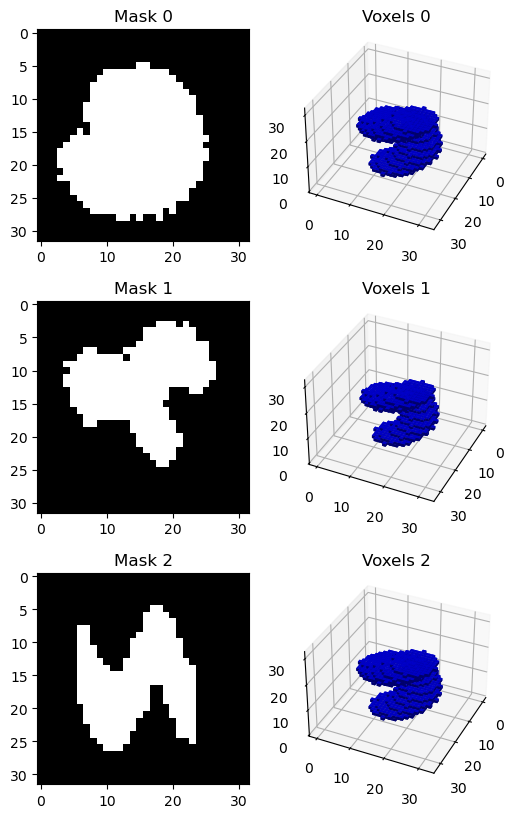

In [3]:
IMAGE_SIZE = (32, 32)

BATCH_SIZE = 100

IMG_FOLDER = "images/spiral"
VOXEL_FOLDER = "voxels/spiral"

train_auto_dataset = datasets.AutoImgCached(IMG_FOLDER, VOXEL_FOLDER, (0, N_TRAIN))
val_auto_dataset = datasets.AutoImgCached(IMG_FOLDER, VOXEL_FOLDER, (N_TRAIN, N_IMGS))

train_auto_loader = torch.utils.data.DataLoader(
    train_auto_dataset, batch_size=BATCH_SIZE, shuffle=True
)
val_auto_loader = torch.utils.data.DataLoader(val_auto_dataset, batch_size=BATCH_SIZE)

display.grid(
    [
        [
            (f"Mask {i}", train_auto_dataset[i][0]),
            (f"Voxels {i}", train_auto_dataset[i][1][1]),
        ]
        for i in range(3)
    ],
    figsize=(6, 10),
)
display.show()

## GAN

To recover the shape, a GAN is used.

### Generator

The generator is a 3D convolutional network. The latent space is mapped linearly to a 32x4x4x4 tensor. This is then repeatedly upsampled using convolutional layer followed by a strided transpose convolution. This doubles the dimensions and halves the number of channels at each stage, to reach a 4x32x32x32 tensor. Finally, this is passed through a resnet block for refinement, and a final convolutional layer to produce a 1x32x32x32 tensor.

This tensor can then be returned, to provide a voxel representation, or a mask is created from a random angle around the cube to produce a 32x32 mask.

### Discriminator

The discriminator is a 2D resnet. This takes in a 32x32 mask, passes it through a resnet block and downsample using a strided convolution, halving the dimensions and doubling the number of channels at each stage. This is until a 4x4 mask is produced, which is then flattened and passed through a linear layer to produce a single label indicating the probability that the mask is real.

In [4]:
LATENT_SIZE = 4
BASE_CHANNELS = 8
DISCRIMINATOR_CHANNELS = 2

discriminator = nnet.generators.MaskDiscriminator(
    base_channels=DISCRIMINATOR_CHANNELS,
    mask_shape=IMAGE_SIZE,
    dropout=0.1,
)

generator = nnet.generators.MaskVoxelGenerator(
    latent_size=LATENT_SIZE,
    base_channels=BASE_CHANNELS,
    space_side_length=SPACE_SIZE[0],
    dropout=0.1,
)

gan_trainer = nnet.training.GANTrainer(
    generator,
    discriminator,
    means=np.zeros(LATENT_SIZE),
    stds=np.ones(LATENT_SIZE),
    lr_gen=1e-3,
    lr_disc=1e-4,
)

In [1]:
MODEL_PATH = "models/spiral_gan"

gan_trainer.train(
    train_auto_loader,
    val_auto_loader,
    71,
    path=MODEL_PATH,
    noise=0.3,
    gen_train_thresh=1.5,
    dis_train_thresh=1.5,
)

NameError: name 'gan_trainer' is not defined

Model models/spiral_gan_0.pt is loaded from epoch 0 , loss 0.7883
Model models/spiral_gan_1.pt is loaded from epoch 10 , loss 0.8267
Model models/spiral_gan_2.pt is loaded from epoch 20 , loss 0.9246
Model models/spiral_gan_3.pt is loaded from epoch 30 , loss 0.5485


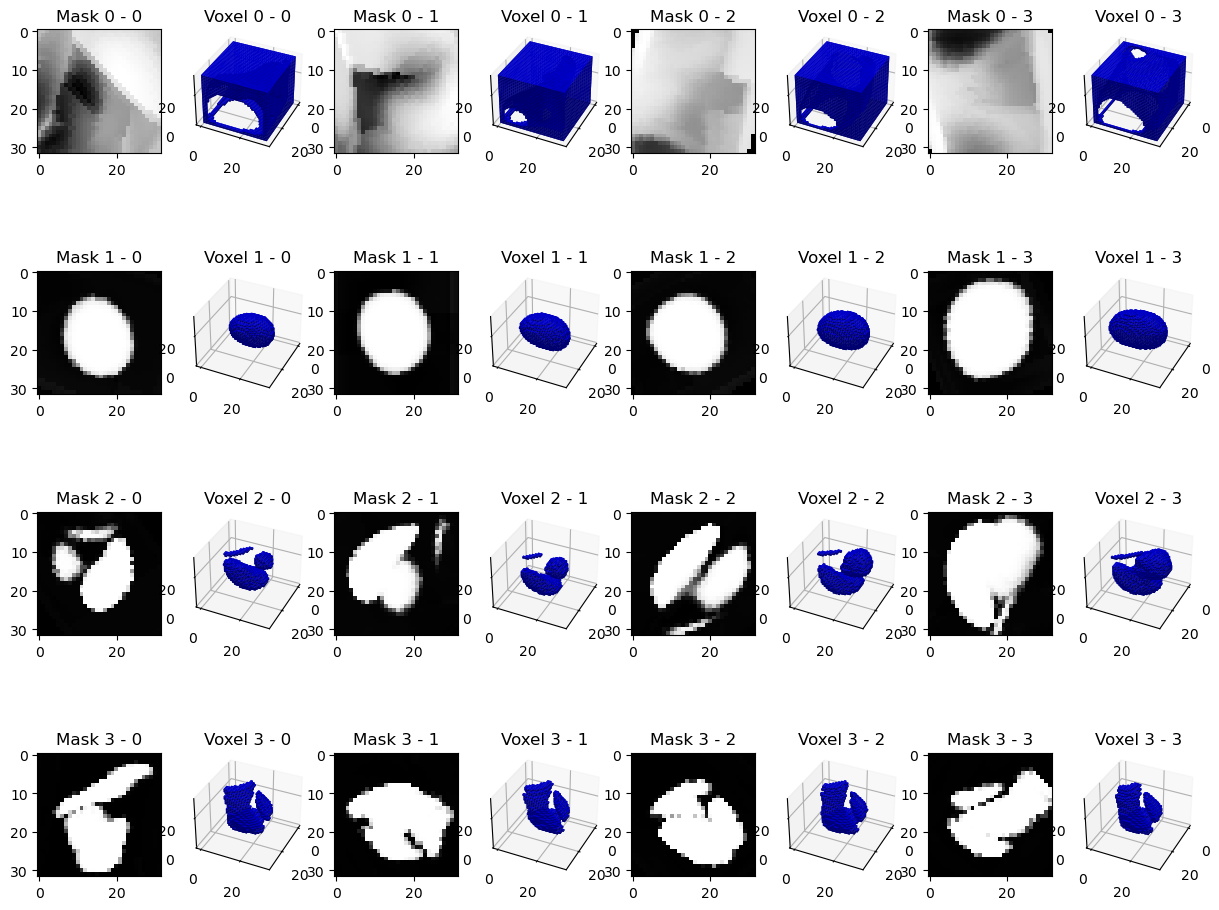

In [8]:
MODELS = (0, 3)
N_SAMPLES = 3

generator.eval()
generator.to("cuda")

N_MODELS = MODELS[1] - MODELS[0] + 1

gen_input = torch.Tensor(
    np.random.normal(0, 1, size=(N_SAMPLES + 1, LATENT_SIZE))
).cuda()

plot_grid = []

for i in range(N_MODELS):
    model_n = MODELS[0] + i
    gan_trainer.load_state(f"{MODEL_PATH}_{model_n}.pt")
    voxel_tensors = generator(gen_input, return_voxels=True)
    mask_tensors = generator(gen_input, return_mask=True)

    masks = [
        metaimage.Mask.from_tensor(mask_tensors[j], title=f"Mask {model_n} - {j}")
        for j in range(N_SAMPLES)
    ]
    voxels = [
        voxel.SimpleVoxel.from_tensor(voxel_tensors[j], title=f"Voxel {model_n} - {j}")
        for j in range(N_SAMPLES)
    ]

    combined = []
    for j in range(N_SAMPLES):
        combined.append(masks[j])
        combined.append(voxels[j])

    plot_grid.append(combined)

display.grid(plot_grid, figsize=(N_SAMPLES * 3.5, 2 * N_MODELS))
display.show()

Model models/ellip_gan_14.pt is loaded from epoch 140 , loss 0.7070


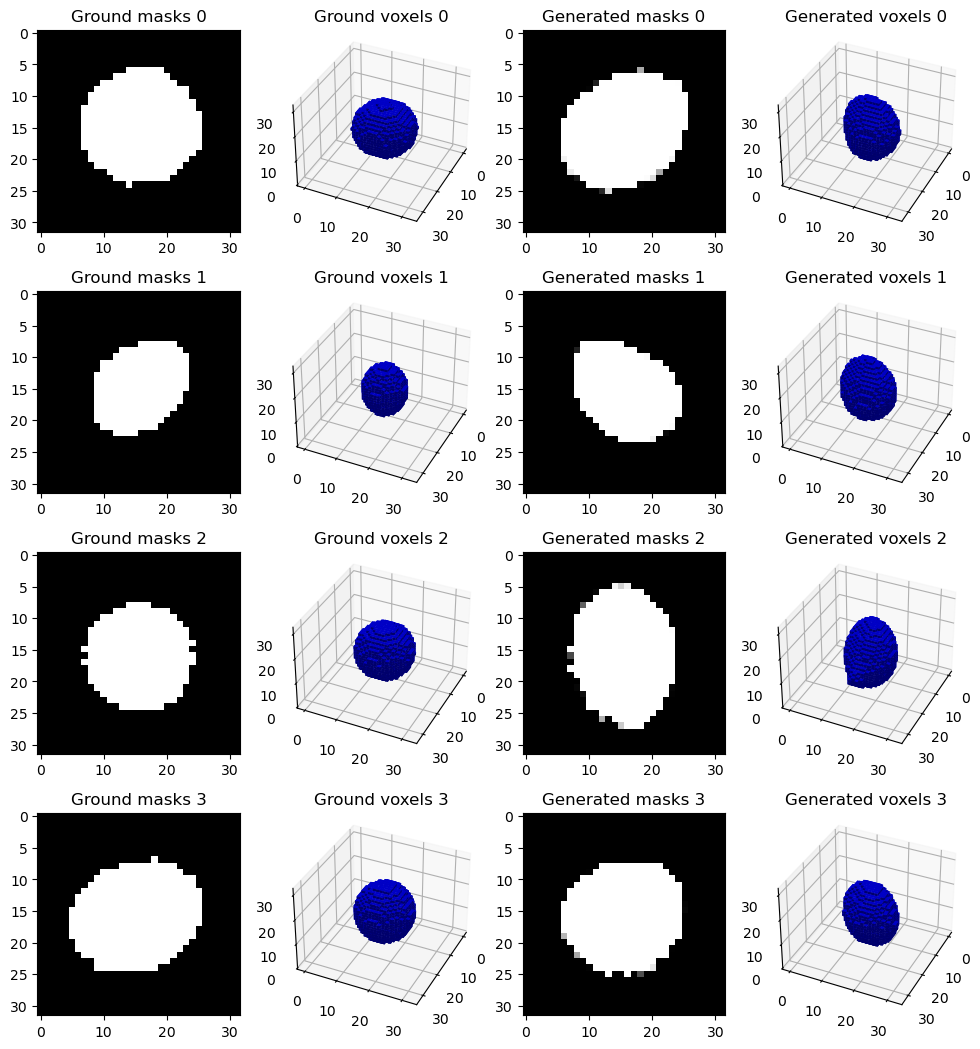

In [ ]:
MODEL = 14

gan_trainer.load_state(f"{MODEL_PATH}_{MODEL}.pt")

gen_input = torch.Tensor(np.random.normal(0, 1, size=(4, LATENT_SIZE))).cuda()

masks = generator(gen_input, return_mask=True)[:4]
voxels = generator(gen_input, return_voxels=True)[:4]

plot_grid = []

for i in range(4):
    cur_voxels = voxel.SimpleVoxel.from_tensor(voxels[i], title=f"Generated voxels {i}")
    cur_mask = metaimage.Mask.from_tensor(masks[i], title=f"Generated masks {i}")
    ground_mask, ground_voxels = train_auto_dataset[i][1]
    ground_mask = metaimage.Mask.from_tensor(ground_mask, title=f"Ground masks {i}")
    ground_voxels = voxel.SimpleVoxel.from_array(
        ground_voxels, title=f"Ground voxels {i}"
    )

    plot_grid.append([ground_mask, ground_voxels, cur_mask, cur_voxels])

display.grid(plot_grid, figsize=(12, 13))
display.show()